<div style="text-align: center;">
    <img src="logo_tsp.png" width="120">

# Network Science and GNN Project

#### First Name: Achraf Nedjmeddine             
#### Last Name: DERRAR  
#### Email: achraf-nedjmeddine.derrar@telecom-sudparis.eu / contactachrafnd@gmail.com  
</div>




## importing necessary libraries

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from abc import ABC, abstractmethod
import random
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score, homogeneity_score
import torch
from torch.nn.functional import one_hot
import scipy.io as sio
import community as community_louvain
import leidenalg
import igraph as ig
from collections import defaultdict
import warnings
import random
from networkx.algorithms.community import girvan_newman



In [18]:
warnings.filterwarnings("ignore")



# Answer 1: Reading the documents (in report)

# Answer 2: Social Network Analysis with the Facebook100 Dataset

### Definining functions

In [19]:
def plot_degree_distribution(graph, network_name):
    # Extract the degree of each node in the graph
    degrees = [d for _, d in graph.degree()]
    
    # Create a histogram of the degree distribution
    plt.hist(degrees, bins=range(1, max(degrees) + 1), density=True, 
             alpha=0.75, edgecolor='black')  # Use density=True for normalized distribution
    
    # Set plot title with the network name
    plt.title(f"Degree Distribution: {network_name}")
    
    # Label x-axis as 'Degree' and y-axis as 'Frequency'
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    
    # Enable grid for better readability
    plt.grid(True)
    
    # Display the plot
    plt.show()


In [20]:
def compute_clustering_coefficients(graph):
    # Compute the global clustering coefficient (also called transitivity)
    global_clustering = nx.transitivity(graph)  
    
    # Compute the average local clustering coefficient
    mean_local_clustering = nx.average_clustering(graph) 
    
    # Return both clustering coefficients as a tuple
    return global_clustering, mean_local_clustering


In [21]:
def compute_edge_density(graph):
    # Get the total number of edges in the graph
    num_edges = graph.number_of_edges()
    
    # Get the total number of nodes in the graph
    num_nodes = graph.number_of_nodes()
    
    # Compute the edge density using the formula:
    # Density = (Number of edges) / (Maximum possible edges in an undirected graph)
    density = num_edges / (num_nodes * (num_nodes - 1) / 2)
    
    # Return the computed density
    return density


In [29]:
def plot_degree_vs_clustering(graph, network_name):
    degrees = dict(graph.degree())
    local_clustering = nx.clustering(graph)

    x = list(degrees.values())
    y = list(local_clustering.values())

    plt.scatter(x, y, alpha=0.6)
    plt.title(f"Degree vs Local Clustering Coefficient: {network_name}")
    plt.xlabel("Degree")
    plt.ylabel("Local Clustering Coefficient")
    plt.grid(True)
    plt.show()

In [30]:
def analyze_network(graph, network_name):
    print(f"Analyzing {network_name}...")
    
    # Plot degree distribution
    plot_degree_distribution(graph, network_name)

    # Compute clustering coefficients
    global_clustering, mean_local_clustering = compute_clustering_coefficients(graph)
    print(f"Global Clustering Coefficient: {global_clustering}")
    print(f"Mean Local Clustering Coefficient: {mean_local_clustering}")

    # Compute edge density
    density = compute_edge_density(graph)
    print(f"Edge Density: {density}")

    # Plot degree vs local clustering coefficient
    plot_degree_vs_clustering(graph, network_name)

#### To do:
- a) plot the degree distribution for each of the three networks
- b) Compute the global clustering coefficient, mean local clustering coefficient and the edge density for each of the 3 networks.
- c) the degree versus local clustering coefficient.

Analyzing Caltech...


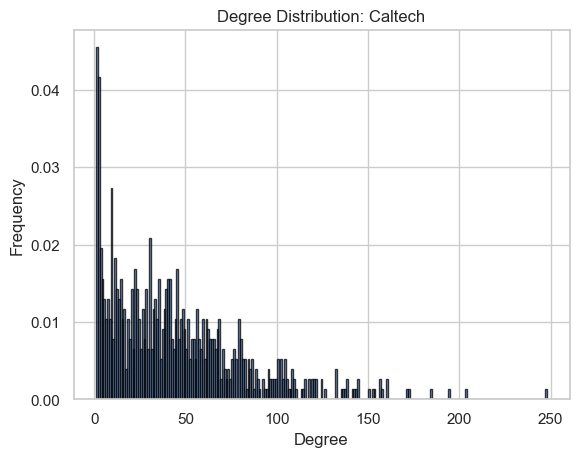

Global Clustering Coefficient: 0.2912826901150874
Mean Local Clustering Coefficient: 0.40929439048517247
Edge Density: 0.05640442132639792


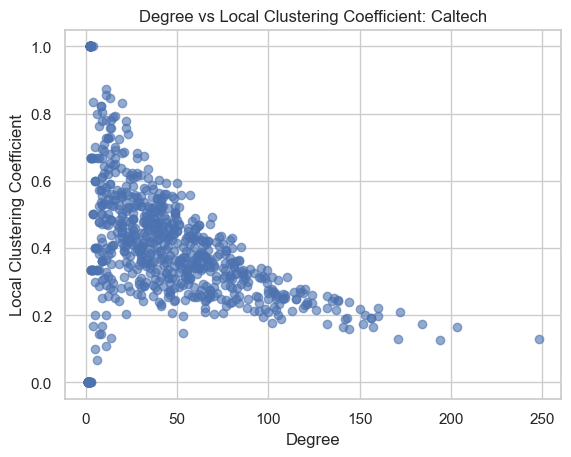

Analyzing MIT...


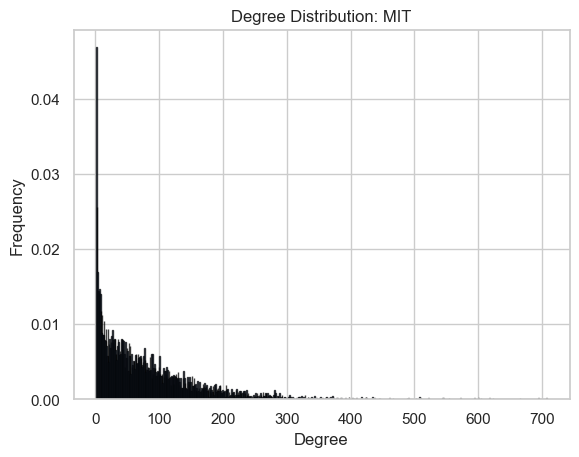

Global Clustering Coefficient: 0.18028845093502427
Mean Local Clustering Coefficient: 0.2712187419501315
Edge Density: 0.012118119495041378


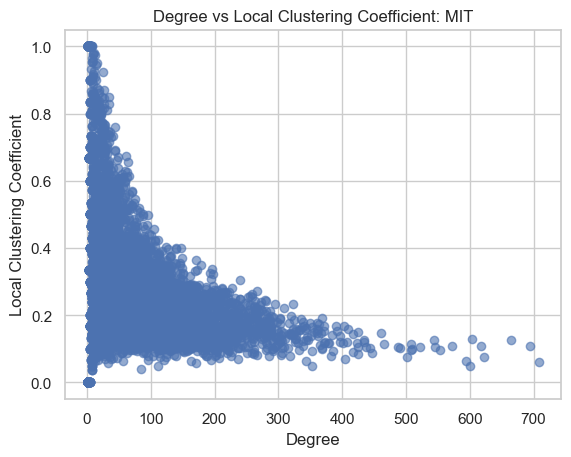

Analyzing Johns Hopkins...


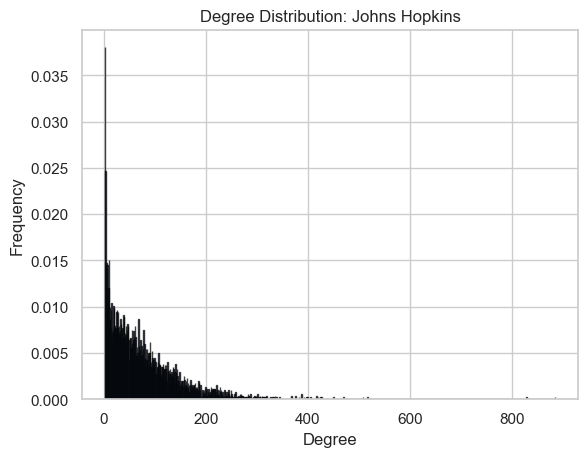

Global Clustering Coefficient: 0.19316123901594015
Mean Local Clustering Coefficient: 0.26839307371293525
Edge Density: 0.013910200162372396


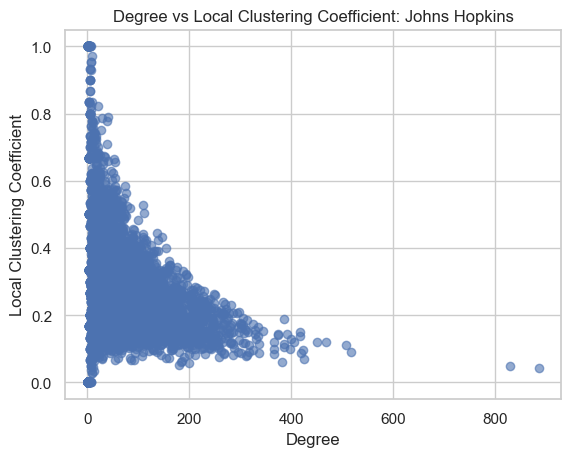

In [31]:
data_folder_path = 'data'
caltech_path = os.path.join(data_folder_path, 'Caltech36.gml')
mit_path = os.path.join(data_folder_path, 'MIT8.gml')
johns_hopkins_path = os.path.join(data_folder_path, 'Johns Hopkins55.gml')

caltech_graph = nx.read_gml(caltech_path, label='id')
mit_graph = nx.read_gml(mit_path, label='id')
johns_hopkins_graph = nx.read_gml(johns_hopkins_path, label='id')

# Analyze the networks: Caltech MIT Johns Hopkins

analyze_network(caltech_graph, "Caltech")
analyze_network(mit_graph, "MIT")
analyze_network(johns_hopkins_graph, "Johns Hopkins")


# Answer 3: Assortativity Analysis with the Facebook100 Dataset

In [32]:
def load_facebook100_data(directory):
    networks = {}
    for file in os.listdir(directory):
        if file.endswith(".gml"):
            graph = nx.read_gml(os.path.join(directory, file))
            networks[file[:-4]] = graph
    return networks

In [33]:
def compute_assortativity(networks, attribute):
    results = {}
    for name, graph in networks.items():
        node_attributes = nx.get_node_attributes(graph, attribute)
        if node_attributes:
            results[name] = nx.attribute_assortativity_coefficient(graph, attribute)
        else:
            results[name] = None
    return results

In [34]:
def plot_density(assortativities, attribute):
    plt.figure(figsize=(10, 6))
    sns.kdeplot([a for a in assortativities if a is not None], shade=True)
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel(f'{attribute.capitalize()} Assortativity')
    plt.ylabel('Density')
    plt.title(f'Density of {attribute.capitalize()} Assortativity')
    plt.show()

In [35]:
def plot_results(network_sizes, assortativities, attribute):

    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(network_sizes, assortativities, alpha=0.6)
    plt.xscale('log')
    plt.axhline(0, color='red', linestyle='--', label='No Assortativity')
    plt.xlabel('Network Size (log-scale)')
    plt.ylabel(f'{attribute.capitalize()} Assortativity')
    plt.title(f'{attribute.capitalize()} Assortativity vs Network Size')
    plt.legend()
    plt.show()

    # Histogram
    plt.figure(figsize=(10, 6))
    plt.hist([a for a in assortativities if a is not None], bins=20, alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', label='No Assortativity')
    plt.xlabel(f'{attribute.capitalize()} Assortativity')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {attribute.capitalize()} Assortativity')
    plt.legend()
    plt.show()

In [36]:
data_directory = "data" 
fb100_networks = load_facebook100_data(data_directory)

### Investigating the assortativity patterns for five vertex 
['student_fac', 'gender', 'major_index', 'dorm', 'year']

Processing assortativity for attribute: student_fac


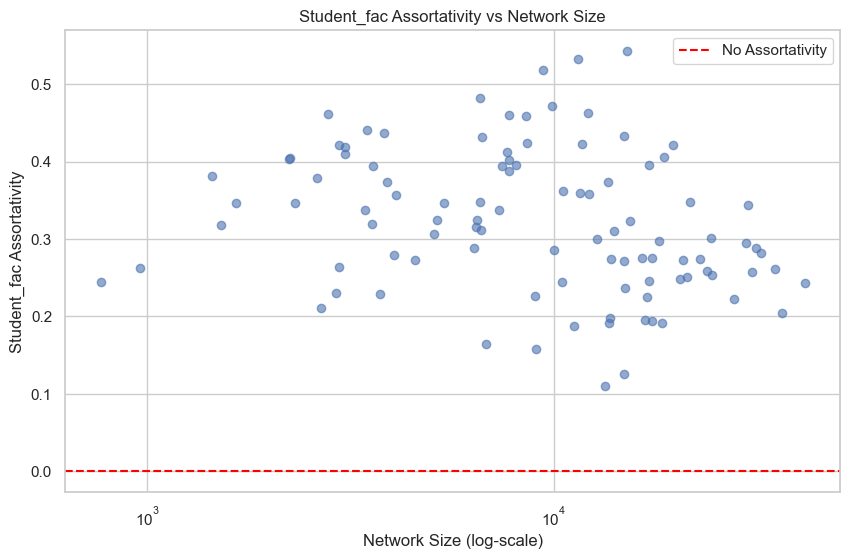

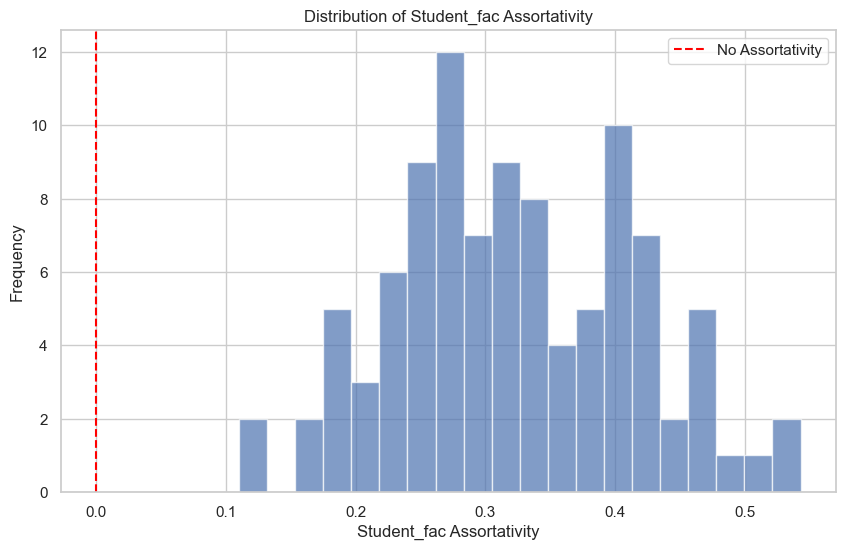

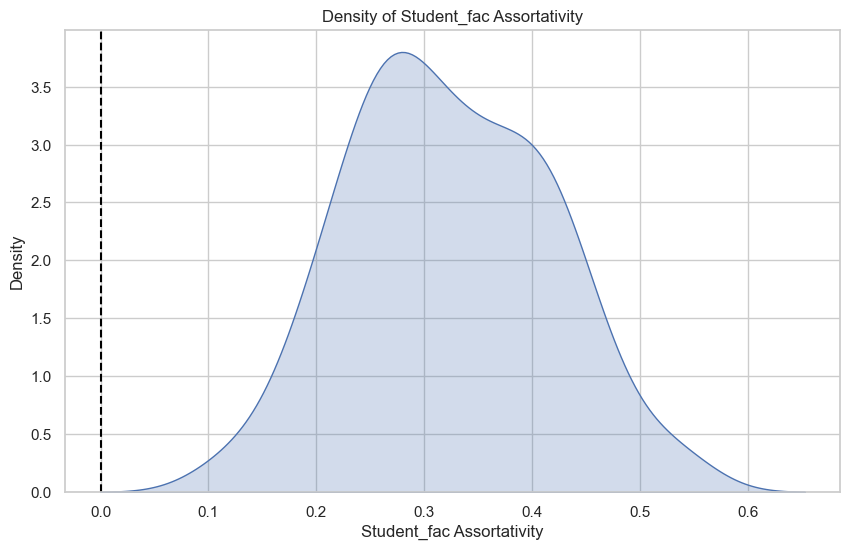

Processing assortativity for attribute: gender


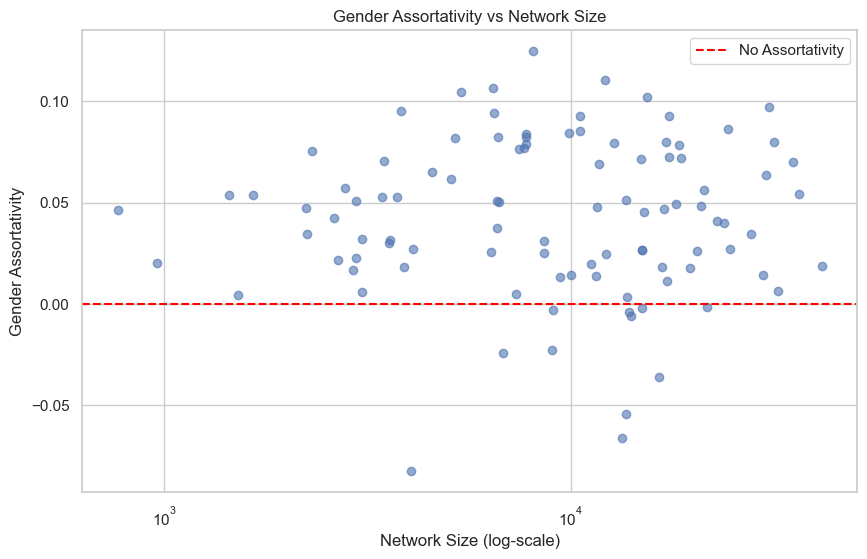

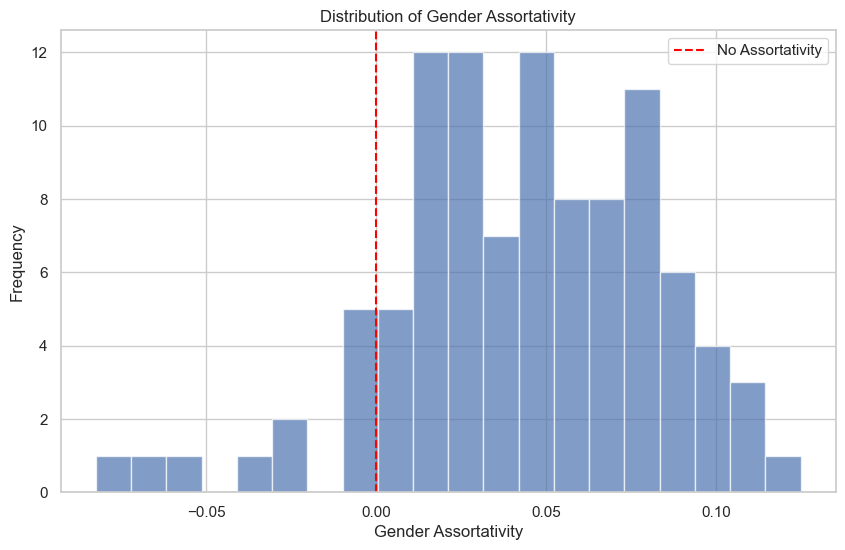

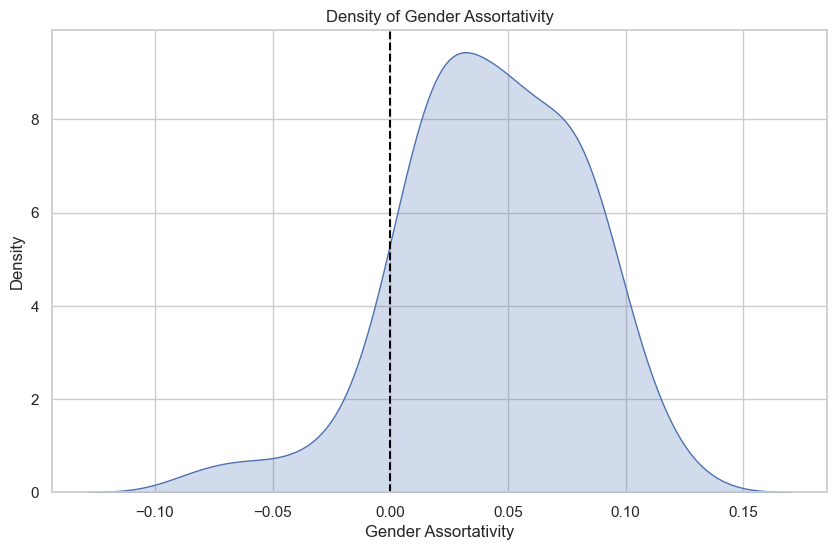

Processing assortativity for attribute: major_index


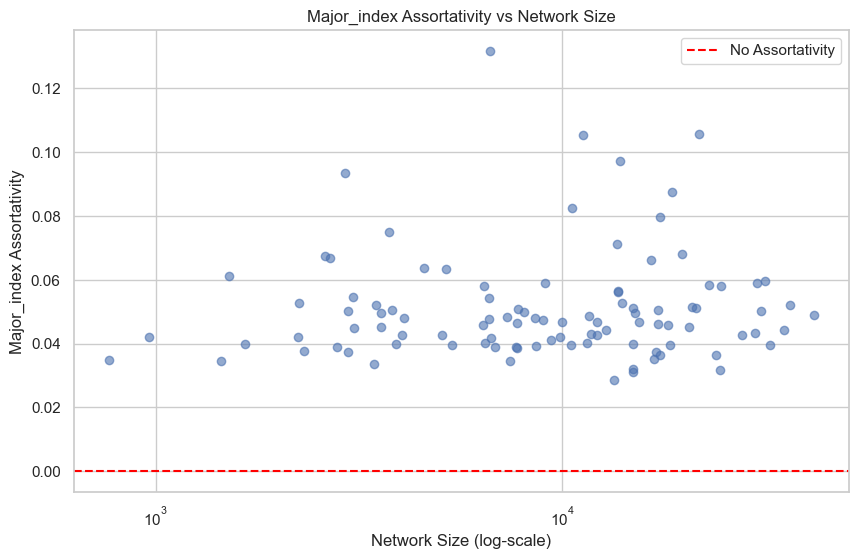

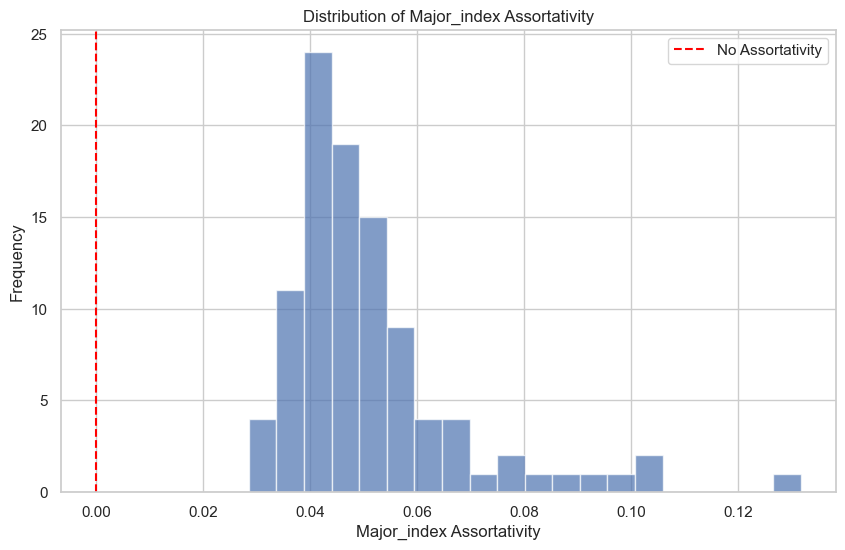

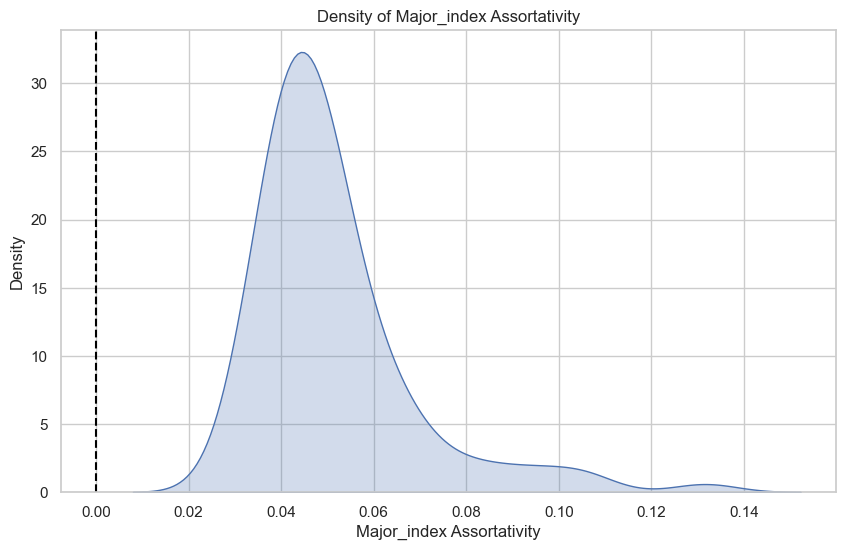

Processing assortativity for attribute: dorm


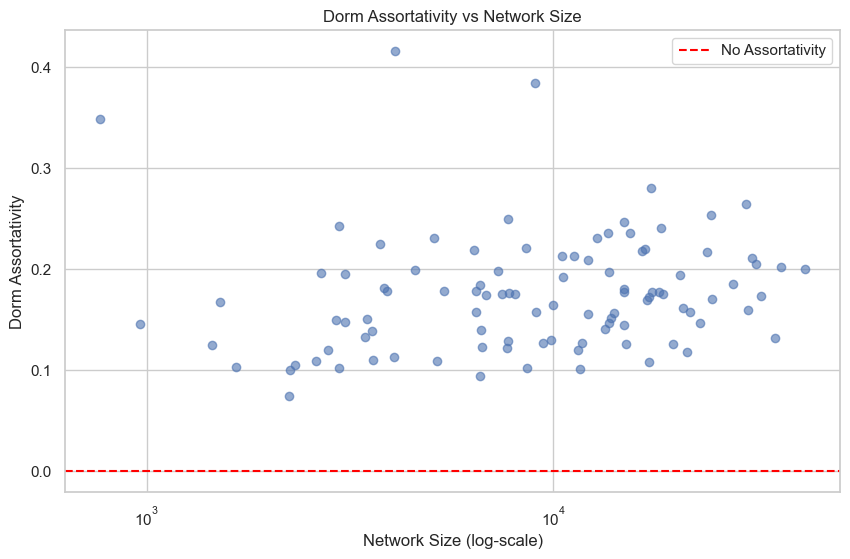

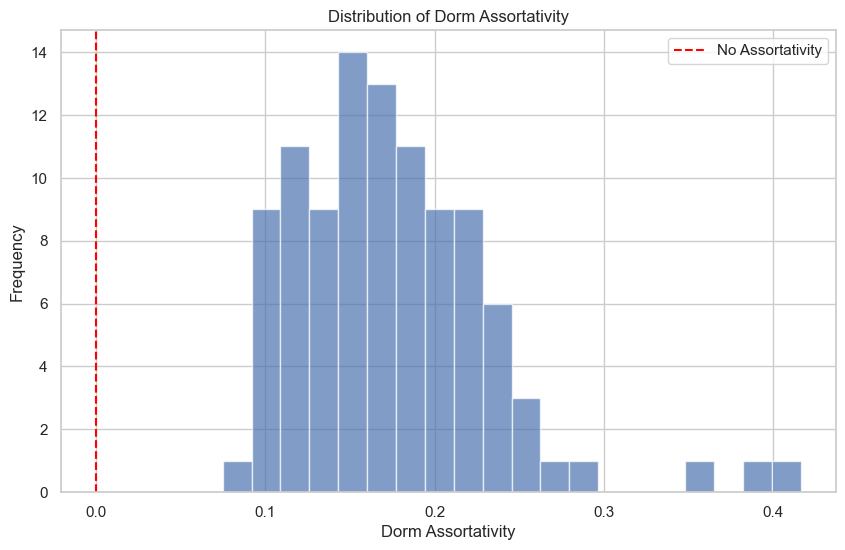

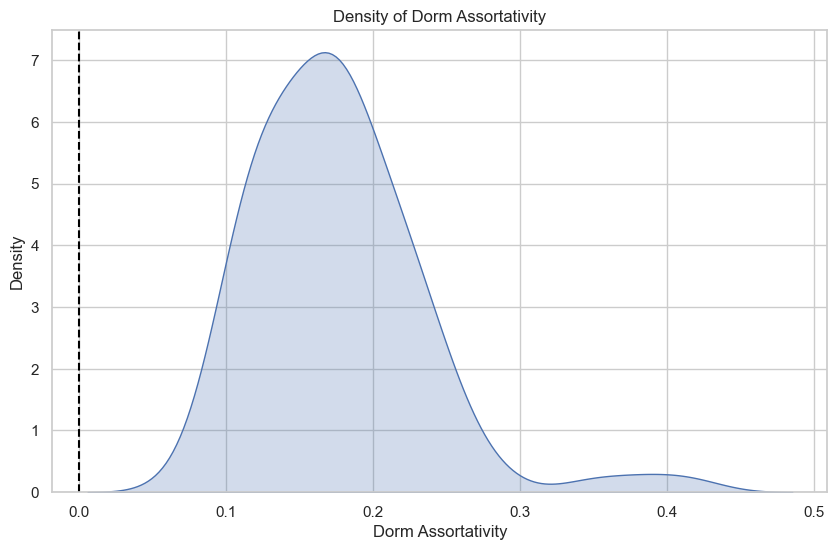

Processing assortativity for attribute: year


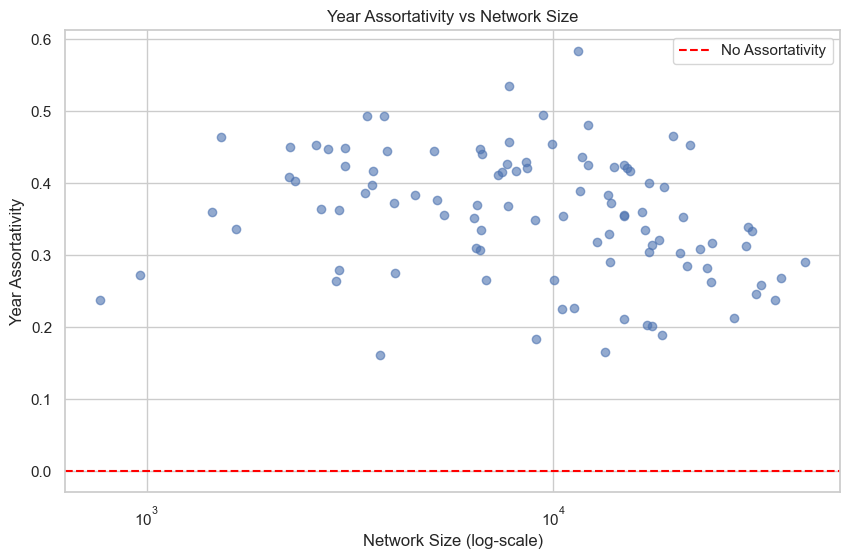

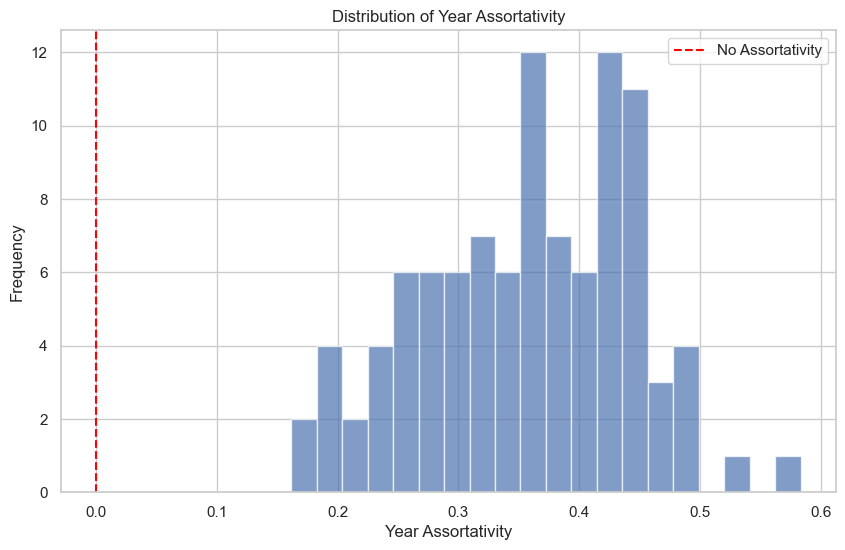

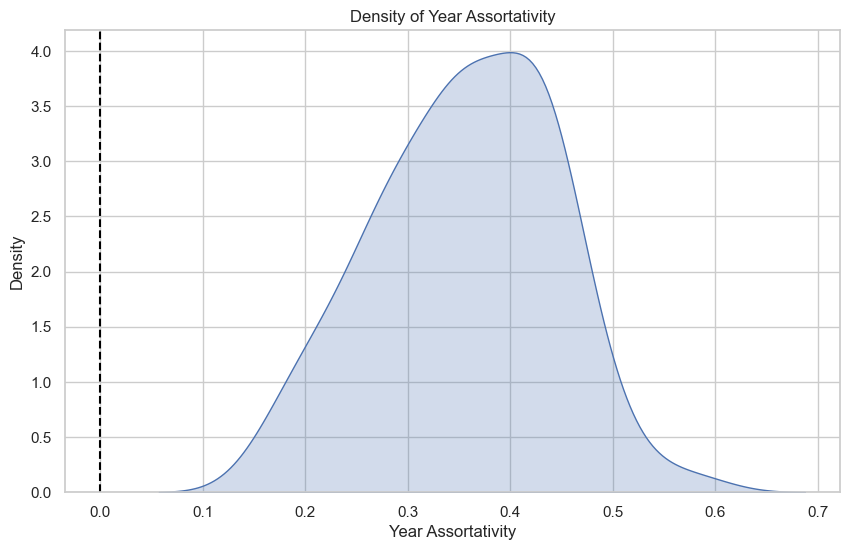

In [37]:
attributes = ['student_fac', 'gender', 'major_index', 'dorm', 'year']


for attribute in attributes:
    print(f"Processing assortativity for attribute: {attribute}")
    assortativity_results = compute_assortativity(fb100_networks, attribute)
    network_sizes = [len(graph) for graph in fb100_networks.values()]
    assortativities = list(assortativity_results.values())
    plot_results(network_sizes, assortativities, attribute) 
    plot_density(assortativities, attribute) # for Density


### Investigating the assortativity for  ["vertex degree"]

In [38]:
def compute_degree_assortativity(networks):
    results = {}
    for name, graph in networks.items():
        try:
            results[name] = nx.degree_assortativity_coefficient(graph)
        except Exception as e:
            results[name] = None
            print(f"Error computing degree assortativity for {name}: {e}")
    return results

Processing degree assortativity


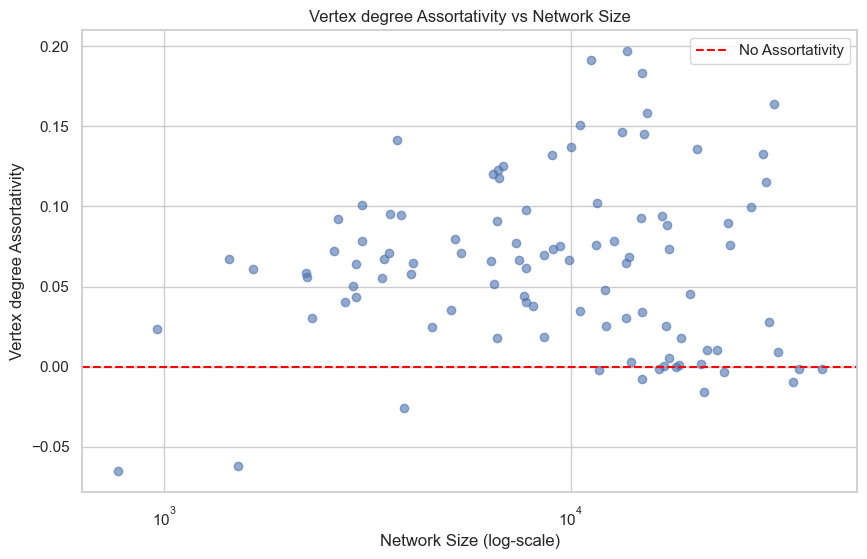

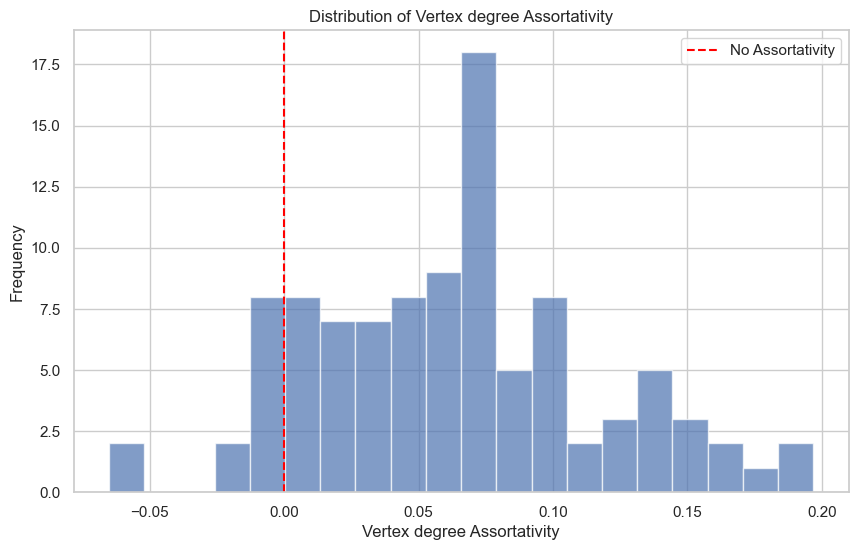

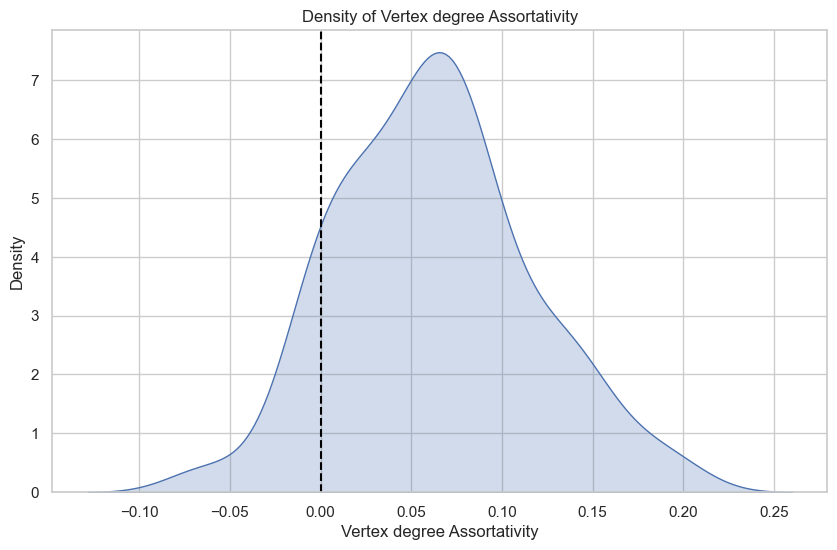

In [39]:
print("Processing degree assortativity")
degree_assortativity_results = compute_degree_assortativity(fb100_networks)
network_sizes = [len(graph) for graph in fb100_networks.values()]
degree_assortativities = list(degree_assortativity_results.values())
plot_results(network_sizes, degree_assortativities, "vertex degree")
plot_density(degree_assortativities, "vertex degree")


# Answer 4: Link prediction

- a) Reading document [4]

- b) implementation

In [40]:
class LinkPrediction(ABC):
    def __init__(self, graph):
        self.graph = graph
        self.N = len(graph)

    def neighbors(self, v):
        return list(self.graph.neighbors(v))

    @abstractmethod
    def fit(self):
        raise NotImplementedError("Fit must be implemented")

- common neighbors

In [41]:
class CommonNeighbors(LinkPrediction):
    def __init__(self, graph):
        super(CommonNeighbors, self).__init__(graph)

    def fit(self, u, v):
        neighbors_u = set(self.neighbors(u))
        neighbors_v = set(self.neighbors(v))
        return len(neighbors_u & neighbors_v)

- jaccard

In [42]:
class Jaccard(LinkPrediction):
    def __init__(self, graph):
        super(Jaccard, self).__init__(graph)

    def fit(self, u, v):
        neighbors_u = set(self.neighbors(u))
        neighbors_v = set(self.neighbors(v))
        intersection = len(neighbors_u & neighbors_v)
        union = len(neighbors_u | neighbors_v)
        return intersection / union if union > 0 else 0

- Adamic/Adar

In [43]:
class AdamicAdar(LinkPrediction):
    def __init__(self, graph):
        super(AdamicAdar, self).__init__(graph)

    def fit(self, u, v):
        neighbors_u = set(self.neighbors(u))
        neighbors_v = set(self.neighbors(v))
        shared_neighbors = neighbors_u & neighbors_v
        return sum(1 / np.log(len(self.neighbors(w))) for w in shared_neighbors if len(self.neighbors(w)) > 1)

- c)  Evaluating a link predictor
- d)  Choosing a couple of graphs in the facebook100 dataset run and evaluate each link predictor on them

In [44]:
def evaluate_link_prediction(graph, link_predictor_class, removed_edges, k_values):
    predictor = link_predictor_class(graph)
    predictions = []

    for u, v in nx.non_edges(graph):
        score = predictor.fit(u, v)
        predictions.append(((u, v), score))

    predictions.sort(key=lambda x: x[1], reverse=True)

    top_k_results = {}
    for k in k_values:
        top_k_edges = {edge for edge, _ in predictions[:k]}
        true_positives = len(top_k_edges & removed_edges)
        precision = true_positives / k
        recall = true_positives / len(removed_edges)
        top_k_results[k] = {
            "Precision": precision,
            "Recall": recall
        }

    return top_k_results


In [45]:
def load_fb100_graph(file_path):
    G = nx.read_gml(file_path, label='id')
    return G

In [46]:
# Define the file path to the graph data
file_path = "data/Caltech36.gml"  

# Load the graph from the specified file path (assumes a function load_fb100_graph is defined elsewhere)
graph = load_fb100_graph(file_path)

# Randomly remove a fraction of edges from the graph
fraction = 0.1  # Fraction of edges to remove (10% in this case)

# Convert the graph's edges to a list to facilitate shuffling
edges = list(graph.edges())

# Shuffle the edges randomly to ensure randomness in the selection of edges to remove
np.random.shuffle(edges)

# Calculate the number of edges to remove based on the fraction
num_removed = int(fraction * len(edges))

# Select the first 'num_removed' edges from the shuffled list
removed_edges = set(edges[:num_removed])

# Remove the selected edges from the graph
graph.remove_edges_from(removed_edges)

# Define the k-values for evaluating the link prediction metrics (i.e., top-k predictions)
k_values = [50, 100, 200, 400]

# Evaluate the Common Neighbors (CN) link prediction metric
print("Evaluating Common Neighbors")
# Call the function to evaluate Common Neighbors on the graph and the removed edges for the given k-values
results_cn = evaluate_link_prediction(graph, CommonNeighbors, removed_edges, k_values)
# Print the results for the Common Neighbors metric
print(results_cn)

# Evaluate the Jaccard link prediction metric
print("Evaluating Jaccard")
# Call the function to evaluate Jaccard on the graph and the removed edges for the given k-values
results_jaccard = evaluate_link_prediction(graph, Jaccard, removed_edges, k_values)
# Print the results for the Jaccard metric
print(results_jaccard)

# Evaluate the Adamic/Adar link prediction metric
print("Evaluating Adamic/Adar")
# Call the function to evaluate Adamic/Adar on the graph and the removed edges for the given k-values
results_adamic_adar = evaluate_link_prediction(graph, AdamicAdar, removed_edges, k_values)
# Print the results for the Adamic/Adar metric
print(results_adamic_adar)

Evaluating Common Neighbors
{50: {'Precision': 0.58, 'Recall': 0.017417417417417418}, 100: {'Precision': 0.52, 'Recall': 0.03123123123123123}, 200: {'Precision': 0.465, 'Recall': 0.055855855855855854}, 400: {'Precision': 0.415, 'Recall': 0.0996996996996997}}
Evaluating Jaccard
{50: {'Precision': 0.4, 'Recall': 0.012012012012012012}, 100: {'Precision': 0.41, 'Recall': 0.024624624624624624}, 200: {'Precision': 0.385, 'Recall': 0.04624624624624624}, 400: {'Precision': 0.3575, 'Recall': 0.08588588588588589}}
Evaluating Adamic/Adar
{50: {'Precision': 0.56, 'Recall': 0.016816816816816817}, 100: {'Precision': 0.54, 'Recall': 0.032432432432432434}, 200: {'Precision': 0.46, 'Recall': 0.05525525525525526}, 400: {'Precision': 0.4175, 'Recall': 0.1003003003003003}}


In [47]:
# Define the file path to the MIT8 graph data
file_path = "data/MIT8.gml"  

# Load the graph from the specified file path (assumes a function load_fb100_graph is defined elsewhere)
graph = load_fb100_graph(file_path)

# Randomly remove a fraction of edges from the graph
fraction = 0.1  # Fraction of edges to remove (10% in this case)

# Convert the graph's edges to a list to facilitate shuffling
edges = list(graph.edges())

# Shuffle the edges randomly to ensure randomness in the selection of edges to remove
np.random.shuffle(edges)

# Calculate the number of edges to remove based on the fraction
num_removed = int(fraction * len(edges))

# Select the first 'num_removed' edges from the shuffled list
removed_edges = set(edges[:num_removed])

# Remove the selected edges from the graph
graph.remove_edges_from(removed_edges)

# Define the k-values for evaluating the link prediction metrics (i.e., top-k predictions)
k_values = [50, 100, 200, 400]

# Evaluate the Common Neighbors (CN) link prediction metric
print("Evaluating Common Neighbors")
# Call the function to evaluate Common Neighbors on the graph and the removed edges for the given k-values
results_cn = evaluate_link_prediction(graph, CommonNeighbors, removed_edges, k_values)
# Print the results for the Common Neighbors metric
print(results_cn)

# Evaluate the Jaccard link prediction metric
print("Evaluating Jaccard")
# Call the function to evaluate Jaccard on the graph and the removed edges for the given k-values
results_jaccard = evaluate_link_prediction(graph, Jaccard, removed_edges, k_values)
# Print the results for the Jaccard metric
print(results_jaccard)

# Evaluate the Adamic/Adar link prediction metric
print("Evaluating Adamic/Adar")
# Call the function to evaluate Adamic/Adar on the graph and the removed edges for the given k-values
results_adamic_adar = evaluate_link_prediction(graph, AdamicAdar, removed_edges, k_values)
# Print the results for the Adamic/Adar metric
print(results_adamic_adar)


Evaluating Common Neighbors
{50: {'Precision': 0.8, 'Recall': 0.0015920398009950248}, 100: {'Precision': 0.79, 'Recall': 0.0031442786069651742}, 200: {'Precision': 0.755, 'Recall': 0.006009950248756219}, 400: {'Precision': 0.6625, 'Recall': 0.01054726368159204}}
Evaluating Jaccard
{50: {'Precision': 0.28, 'Recall': 0.0005572139303482587}, 100: {'Precision': 0.33, 'Recall': 0.0013134328358208956}, 200: {'Precision': 0.26, 'Recall': 0.0020696517412935322}, 400: {'Precision': 0.3475, 'Recall': 0.005532338308457711}}
Evaluating Adamic/Adar
{50: {'Precision': 0.82, 'Recall': 0.0016318407960199005}, 100: {'Precision': 0.81, 'Recall': 0.0032238805970149255}, 200: {'Precision': 0.765, 'Recall': 0.0060895522388059705}, 400: {'Precision': 0.685, 'Recall': 0.01090547263681592}}


In [48]:
# Define the file path to the Johns Hopkins55 graph data
file_path = "data/Johns Hopkins55.gml"  

# Load the graph from the specified file path (assumes a function load_fb100_graph is defined elsewhere)
graph = load_fb100_graph(file_path)

# Randomly remove a fraction of edges from the graph
fraction = 0.1  # Fraction of edges to remove (10% in this case)

# Convert the graph's edges to a list to facilitate shuffling
edges = list(graph.edges())

# Shuffle the edges randomly to ensure randomness in the selection of edges to remove
np.random.shuffle(edges)

# Calculate the number of edges to remove based on the fraction
num_removed = int(fraction * len(edges))

# Select the first 'num_removed' edges from the shuffled list
removed_edges = set(edges[:num_removed])

# Remove the selected edges from the graph
graph.remove_edges_from(removed_edges)

# Define the k-values for evaluating the link prediction metrics (i.e., top-k predictions)
k_values = [50, 100, 200, 400]

# Evaluate the Common Neighbors (CN) link prediction metric
print("Evaluating Common Neighbors")
# Call the function to evaluate Common Neighbors on the graph and the removed edges for the given k-values
results_cn = evaluate_link_prediction(graph, CommonNeighbors, removed_edges, k_values)
# Print the results for the Common Neighbors metric
print(results_cn)

# Evaluate the Jaccard link prediction metric
print("Evaluating Jaccard")
# Call the function to evaluate Jaccard on the graph and the removed edges for the given k-values
results_jaccard = evaluate_link_prediction(graph, Jaccard, removed_edges, k_values)
# Print the results for the Jaccard metric
print(results_jaccard)

# Evaluate the Adamic/Adar link prediction metric
print("Evaluating Adamic/Adar")
# Call the function to evaluate Adamic/Adar on the graph and the removed edges for the given k-values
results_adamic_adar = evaluate_link_prediction(graph, AdamicAdar, removed_edges, k_values)
# Print the results for the Adamic/Adar metric
print(results_adamic_adar)

Evaluating Common Neighbors
{50: {'Precision': 0.76, 'Recall': 0.002036659877800407}, 100: {'Precision': 0.72, 'Recall': 0.003858934505306035}, 200: {'Precision': 0.7, 'Recall': 0.00750348376031729}, 400: {'Precision': 0.68, 'Recall': 0.01457819702004502}}
Evaluating Jaccard
{50: {'Precision': 0.24, 'Recall': 0.0006431557508843392}, 100: {'Precision': 0.4, 'Recall': 0.002143852502947797}, 200: {'Precision': 0.475, 'Recall': 0.0050916496945010185}, 400: {'Precision': 0.4575, 'Recall': 0.009808125200986171}}
Evaluating Adamic/Adar
{50: {'Precision': 0.78, 'Recall': 0.0020902561903741023}, 100: {'Precision': 0.67, 'Recall': 0.0035909529424375604}, 200: {'Precision': 0.68, 'Recall': 0.00728909851002251}, 400: {'Precision': 0.6875, 'Recall': 0.014738985957766106}}


# Answer 5: Find missing labels with the label propagation algorithms

- a) reading the document (in report)
- b) Implementing the label propagation algorithm

In [56]:
class LabelPropagation:
    def __init__(self, graph):
        """
        Initialize the LabelPropagation object with a graph.

        Parameters:
        graph: A NetworkX graph object, which will be used for label propagation.
        """
        self.graph = graph
        
    def propagate_labels(self, labels, max_iter=100):
        """
        Perform label propagation to predict labels for unlabeled nodes.

        Parameters:
        labels: numpy array with initial labels (use -1 for unlabeled nodes)
        max_iter: maximum number of iterations for propagation

        Returns:
        numpy array with the final propagated labels
        """
        # Convert graph nodes into a list and calculate number of nodes
        nodes = list(self.graph.nodes())
        n = len(nodes)
        
        # Initialize a label matrix where each row corresponds to a node, and columns represent each possible label.
        # The matrix is one-hot encoded (e.g., [1, 0, 0] means label 0 is assigned to the node).
        label_matrix = np.zeros((n, labels.max() + 1))
        
        # Fill the label matrix with the initial labels
        for i, label in enumerate(labels):
            if label != -1:  # Only set the label for nodes that are labeled
                label_matrix[i, label] = 1
        
        # Get the adjacency matrix of the graph (a matrix representation of node connections)
        adj_matrix = nx.to_numpy_array(self.graph)

        # Perform label propagation for a maximum of `max_iter` iterations
        for _ in range(max_iter):
            # Propagate the labels using the adjacency matrix and update the label matrix
            label_matrix = np.dot(adj_matrix, label_matrix)
            
            # Normalize the label matrix so that each row sums to 1 (probabilities)
            label_matrix /= label_matrix.sum(axis=1, keepdims=True)
            
        # After propagation, each row of the label matrix represents the likelihood of each label for a node.
        # Take the label with the highest probability (index of the maximum value)
        propagated_labels = label_matrix.argmax(axis=1)
        
        return propagated_labels

    def evaluate(self, true_labels, predicted_labels):
        """
        Evaluate the performance of the label propagation algorithm by calculating accuracy and mean absolute error.

        Parameters:
        true_labels: numpy array containing the true labels for the nodes
        predicted_labels: numpy array containing the labels predicted by the label propagation algorithm

        Returns:
        accuracy: proportion of correctly predicted labels
        mae: mean absolute error between the true and predicted labels
        """
        # Mask for nodes that are labeled (true label != -1)
        mask = true_labels != -1
        
        # Select only the true and predicted labels for the labeled nodes
        true = true_labels[mask]
        pred = predicted_labels[mask]
        
        # Calculate accuracy and mean absolute error
        accuracy = accuracy_score(true, pred)
        mae = mean_absolute_error(true, pred)
        
        return accuracy, mae


- c) Randomly select 10 graphs and perform label propagation for selected files

In [57]:
gml_folder_path = "data"

# List all .gml files in the folder
gml_files = [f for f in os.listdir(gml_folder_path) if f.endswith('.gml')]

# Randomly select 10 .gml files
selected_files = random.sample(gml_files, 10)

In [58]:
# Load the graphs and perform label propagation for selected files
results = []
for file in selected_files:
    file_path = os.path.join(gml_folder_path, file)
    graph = nx.read_edgelist(file_path)
    print(f"Processing {file}...")

    # Assign random labels to nodes
    attributes = np.array([random.randint(0, 3) for _ in range(len(graph))]) 
    print(f"Attributes: {attributes}")
    
    # Remove a percentage of attributes
    missing_fraction = 0.2
    mask = np.random.rand(len(attributes)) > missing_fraction
    partial_labels = np.where(mask, attributes, -1)

    # Run label propagation
    lp = LabelPropagation(graph)
    predicted_labels = lp.propagate_labels(partial_labels)

    # Evaluate results
    accuracy, mae = lp.evaluate(attributes, predicted_labels)
    print(f"Accuracy: {accuracy}, Mean Absolute Error: {mae}")


Processing Columbia2.gml...
Attributes: [1 3 3 ... 1 1 3]
Accuracy: 0.2522582152312724, Mean Absolute Error: 1.2295203239370815
Processing UVA16.gml...
Attributes: [3 3 1 ... 3 0 2]
Accuracy: 0.25128659177688006, Mean Absolute Error: 1.4982568756571302
Processing Mississippi66.gml...
Attributes: [3 1 2 ... 3 3 2]
Accuracy: 0.2557636887608069, Mean Absolute Error: 1.4824387608069165
Processing Indiana69.gml...
Attributes: [2 2 3 ... 0 1 2]
Accuracy: 0.2506810631229236, Mean Absolute Error: 0.9996677740863787
Processing Baylor93.gml...
Attributes: [3 2 1 ... 1 0 0]
Accuracy: 0.2540306291086709, Mean Absolute Error: 0.9929486944066988
Processing MIT8.gml...
Attributes: [0 1 0 ... 0 2 1]
Accuracy: 0.24604345493562232, Mean Absolute Error: 1.501475321888412
Processing Syracuse56.gml...
Attributes: [2 2 3 ... 1 1 1]
Accuracy: 0.25015941202134445, Mean Absolute Error: 1.5029700976608384
Processing Bucknell39.gml...
Attributes: [0 1 0 ... 0 0 1]
Accuracy: 0.25655532586225654, Mean Absolute Err

In [59]:
class LabelPropagation:
    def __init__(self, graph):
        self.graph = graph
        
    def propagate_labels(self, labels, max_iter=100):
        """
        Perform label propagation using PyTorch for matrix operations.

        Parameters:
        labels: numpy array with initial labels (use -1 for unlabeled nodes)
        max_iter: maximum number of iterations

        Returns:
        numpy array with final labels
        """
        nodes = list(self.graph.nodes())
        n = len(nodes)
        num_classes = labels.max() + 1

        # Initialize label matrix with PyTorch
        label_matrix = torch.zeros((n, num_classes), dtype=torch.float32)
        for i, label in enumerate(labels):
            if label != -1:
                label_matrix[i, label] = 1.0

        # Convert adjacency matrix to PyTorch tensor
        adj_matrix = torch.tensor(nx.to_numpy_array(self.graph), dtype=torch.float32)

        for _ in range(max_iter):
            # Propagate labels using matrix multiplication
            label_matrix = torch.matmul(adj_matrix, label_matrix)

            # Normalize rows to prevent exploding values
            row_sums = label_matrix.sum(dim=1, keepdim=True)
            row_sums[row_sums == 0] = 1  # Avoid division by zero
            label_matrix = label_matrix / row_sums

        propagated_labels = torch.argmax(label_matrix, dim=1).numpy()
        return propagated_labels

    def evaluate(self, true_labels, predicted_labels):
        """
        Evaluate the accuracy and mean absolute error.

        Parameters:
        true_labels: numpy array of true labels
        predicted_labels: numpy array of predicted labels

        Returns:
        accuracy, mean absolute error
        """
        mask = true_labels != -1
        true = true_labels[mask]
        pred = predicted_labels[mask]
        
        accuracy = accuracy_score(true, pred)
        mae = mean_absolute_error(true, pred)
        f1 = f1_score(true, pred, average='weighted')  # Weighted F1-score for imbalanced classes
        
        return accuracy, mae, f1


- for the attributes: ”dorm”, ”major”, ”gender”, "year"

In [60]:
# Load the graph
fb_graph_path = "data/Princeton12.gml"
graph = nx.read_edgelist(fb_graph_path)

# Attributes to test
attributes_dict = {
    "dorm": np.array([random.randint(0, 4) for _ in range(len(graph))]),  
    "major": np.array([random.randint(0, 10) for _ in range(len(graph))]), 
    "gender": np.array([random.randint(0, 1) for _ in range(len(graph))]),  
    "year": np.array([random.randint(0, 3) for _ in range(len(graph))])  
}

# Fractions to remove
fractions = [0.1, 0.2, 0.3, 0.4]

results = []

for attr_name, attributes in attributes_dict.items():
    for fraction in fractions:
        mask = np.random.rand(len(attributes)) > fraction
        partial_labels = np.where(mask, attributes, -1)

        # Run label propagation
        lp = LabelPropagation(graph)
        predicted_labels = lp.propagate_labels(partial_labels)

        # Evaluate results
        accuracy, mae, f1 = lp.evaluate(attributes, predicted_labels)
        results.append((attr_name, fraction, accuracy, mae, f1))
        print(f"Attribute: {attr_name}, Missing Fraction: {fraction}, Accuracy: {accuracy}, MAE: {mae}, F1-Score: {f1}")




Attribute: dorm, Missing Fraction: 0.1, Accuracy: 0.20629300554479257, MAE: 1.7143429754826642, F1-Score: 0.11973705862394511
Attribute: dorm, Missing Fraction: 0.2, Accuracy: 0.20635981027456743, MAE: 1.7138085376444652, F1-Score: 0.11817385810652169
Attribute: dorm, Missing Fraction: 0.3, Accuracy: 0.2064266150043423, MAE: 1.7140757565635647, F1-Score: 0.11980339476108723
Attribute: dorm, Missing Fraction: 0.4, Accuracy: 0.20635981027456743, MAE: 1.7138085376444652, F1-Score: 0.11817385810652169
Attribute: major, Missing Fraction: 0.1, Accuracy: 0.09553076357806133, MAE: 3.0533769790901197, F1-Score: 0.03027641053806884
Attribute: major, Missing Fraction: 0.2, Accuracy: 0.09486271628031265, MAE: 4.317522880619948, F1-Score: 0.02982975517530486
Attribute: major, Missing Fraction: 0.3, Accuracy: 0.09492952101008752, MAE: 2.861179771527824, F1-Score: 0.030442588304145545
Attribute: major, Missing Fraction: 0.4, Accuracy: 0.09272496492751686, MAE: 3.740664039013962, F1-Score: 0.028080778

In [62]:
# Display results
results_df = pd.DataFrame(results, columns=["Attribute", "Missing Fraction", "Accuracy", "MAE", "F1-Score"])
results_df

,Attribute,Missing Fraction,Accuracy,MAE,F1-Score
0,dorm,0.1,0.206293,1.714343,0.119737
1,dorm,0.2,0.206360,1.713809,0.118174
2,dorm,0.3,0.206427,1.714076,0.119803
3,dorm,0.4,0.206360,1.713809,0.118174
4,major,0.1,0.095531,3.053377,0.030276
5,major,0.2,0.094863,4.317523,0.029830
6,major,0.3,0.094930,2.861180,0.030443
7,major,0.4,0.092725,3.740664,0.028081
8,gender,0.1,0.504309,0.495691,0.338206
9,gender,0.2,0.499566,0.500434,0.497866


#### In conclusion, more predictable labels (like gender) result in higher accuracy, while more variable labels (like major) lead to lower accuracy in label propagation.

# Answer 6: Communities detection with the FB100 datasets

- a) Formulating a research question about group formation in FB100 and explaining hypothesis (in report).
- b) writing code and results:

In [63]:
def load_fb100_graphs_from_directory(directory, num_files=5):
   
    all_files = [file for file in os.listdir(directory) if file.endswith(".gml")]
    selected_files = random.sample(all_files, num_files)  # Randomly select files

    networks = {}
    for file in selected_files:
        gml_path = os.path.join(directory, file)
        try:
            graph = nx.read_gml(gml_path)
            network_name = file[:-4]  # Remove '.gml' extension
            networks[network_name] = graph
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return networks

In [64]:
def detect_communities_louvain(G):
   
    # best_partition returns a dict: node -> community id
    partition = community_louvain.best_partition(G)
    return partition

In [65]:
def detect_communities_girvan_newman(G, num_communities=5):

    communities_generator = girvan_newman(G)
    limited = []
    try:
        for communities in communities_generator:
            limited = communities
            if len(limited) >= num_communities:
                break
    except:
        pass
    partition = {}
    for idx, community in enumerate(limited):
        for node in community:
            partition[node] = idx
    return partition

In [66]:
def detect_communities_leiden(G):

    # Convert NetworkX graph to igraph
    ig_graph = ig.Graph.from_networkx(G)
    # Apply Leiden algorithm
    partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)
    # Map back to node IDs
    node_to_comm = {node: comm for node, comm in zip(G.nodes(), partition.membership)}
    return node_to_comm

In [67]:
def compute_modularity_louvain(G, partition):

    return community_louvain.modularity(partition, G)

In [68]:
def compute_modularity_leiden(G, partition):

    # Leiden algorithm already optimizes modularity, but we can compute it
    modularity = leidenalg.ModularityVertexPartition(G, membership=list(partition.values())).modularity
    return modularity

In [69]:
def analyze_homogeneity(G, partition, attribute):

    # Create a list where index is node and value is community
    communities = defaultdict(list)
    for node, comm in partition.items():
        communities[comm].append(node)
    
    homogeneity_scores = []
    for comm, nodes in communities.items():
        # Extract attribute values
        attr_values = [G.nodes[node][attribute] for node in nodes if attribute in G.nodes[node]]
        if len(attr_values) < 2:
            continue  # Homogeneity is not defined for a single element
        # Calculate the most common attribute in the community
        most_common = max(set(attr_values), key=attr_values.count)
        # Calculate homogeneity: proportion of nodes with the most common attribute
        homogeneity = attr_values.count(most_common) / len(attr_values)
        homogeneity_scores.append(homogeneity)
    
    # Return average homogeneity across all communities
    if homogeneity_scores:
        return sum(homogeneity_scores) / len(homogeneity_scores)
    else:
        return 0


In [70]:
fb100_directory = "data"  

# Load networks
networks = load_fb100_graphs_from_directory(fb100_directory)
print(f"Loaded {len(networks)} FB100 networks.\n")

selected_networks = list(networks.keys())[:5]

results = []

for net_name in selected_networks:
    G = networks[net_name]
    print(f"Analyzing Network: {net_name}")
    print(f" - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    
    if not all(attr in G.nodes[next(iter(G.nodes()))] for attr in ['major_index', 'year']):
        print(" - Skipping due to missing 'major_index' or 'year' attributes.\n")
        continue
    
    
    partition = detect_communities_louvain(G)
    modularity = compute_modularity_louvain(G, partition)
    homogeneity_major = analyze_homogeneity(G, partition, 'major_index')
    homogeneity_year = analyze_homogeneity(G, partition, 'year')

    results.append({
        'Network': net_name,
        'Modularity': modularity,
        'Homogeneity_Major': homogeneity_major,
        'Homogeneity_Year': homogeneity_year,
        'Num_Communities': len(set(partition.values()))
    })


Loaded 5 FB100 networks.

Analyzing Network: Wesleyan43
 - Nodes: 3593, Edges: 138035
Analyzing Network: UC64
 - Nodes: 6833, Edges: 155332
Analyzing Network: Harvard1
 - Nodes: 15126, Edges: 824617
Analyzing Network: Johns Hopkins55
 - Nodes: 5180, Edges: 186586
Analyzing Network: UNC28
 - Nodes: 18163, Edges: 766800


In [71]:
# Convert results to DataFrame for better visualization
df_results = pd.DataFrame(results)

# Save the DataFrame as CSV for download
output_path = 'Louvain_Community_Detection_Results.csv'
df_results.to_csv(output_path, index=False)


df_results


,Network,Modularity,Homogeneity_Major,Homogeneity_Year,Num_Communities
0,Wesleyan43,0.445258,0.331887,0.569995,8
1,UC64,0.447773,0.395166,0.566210,23
2,Harvard1,0.442581,0.559765,0.724620,34
3,Johns Hopkins55,0.441970,0.445128,0.668307,19
4,UNC28,0.426715,0.300543,0.453410,13


## Plotting the results

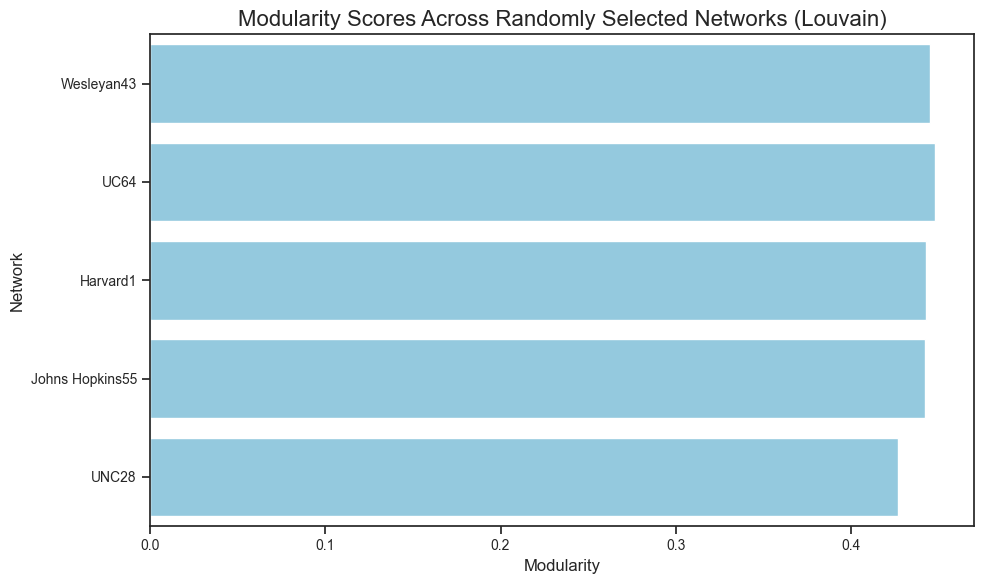

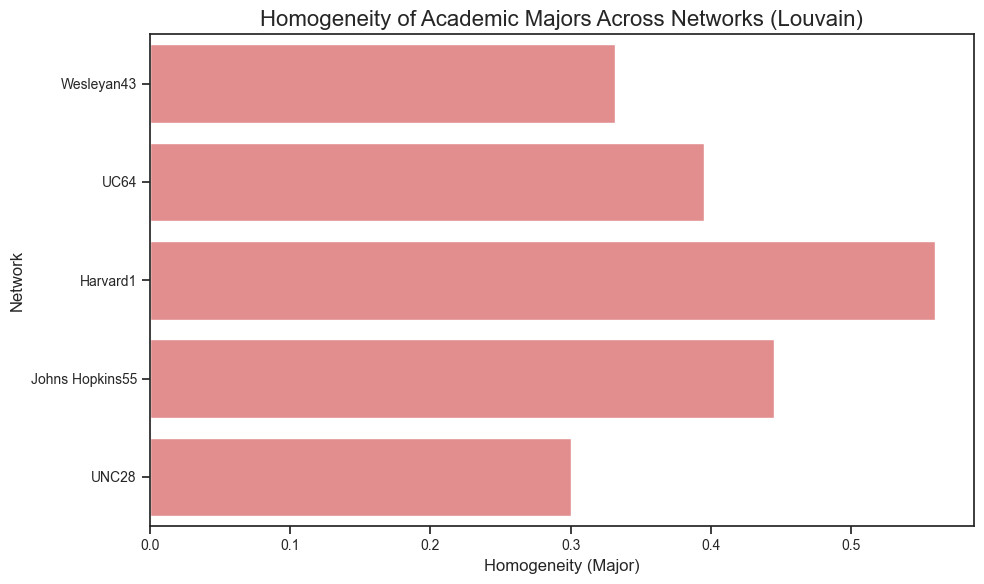

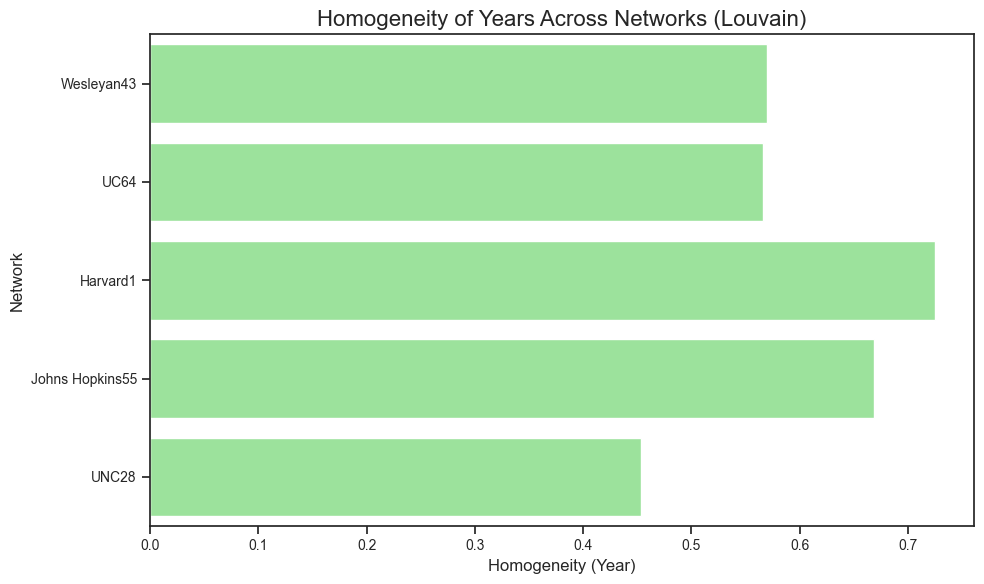

In [72]:
# Set a custom style
sns.set(style="ticks", palette="pastel")

# Plot Modularity Scores with horizontal bars and custom color
plt.figure(figsize=(10, 6))
sns.barplot(x='Modularity', y='Network', data=df_results, color='skyblue')
plt.title('Modularity Scores Across Randomly Selected Networks (Louvain)', fontsize=16)
plt.xlabel('Modularity', fontsize=12)
plt.ylabel('Network', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Homogeneity Scores for Major with horizontal bars and custom color
plt.figure(figsize=(10, 6))
sns.barplot(x='Homogeneity_Major', y='Network', data=df_results, color='lightcoral')
plt.title('Homogeneity of Academic Majors Across Networks (Louvain)', fontsize=16)
plt.xlabel('Homogeneity (Major)', fontsize=12)
plt.ylabel('Network', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Homogeneity Scores for Year with horizontal bars and custom color
plt.figure(figsize=(10, 6))
sns.barplot(x='Homogeneity_Year', y='Network', data=df_results, color='lightgreen')
plt.title('Homogeneity of Years Across Networks (Louvain)', fontsize=16)
plt.xlabel('Homogeneity (Year)', fontsize=12)
plt.ylabel('Network', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
